In [1]:
import csv
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import itertools as it
import numpy.matlib as nm
from sklearn import metrics
import sklearn.model_selection as ms
import sklearn.metrics as metrics
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn import linear_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn 
from scipy.stats import poisson
import statsmodels.api as sm
from numpy import random as rn
from scipy import stats
from fitter import Fitter, get_common_distributions
from scipy.stats import weibull_max
from tqdm import tqdm
from scipy.integrate import quad
from ipywidgets import interact, FloatSlider, IntSlider
import scipy.interpolate as interp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
short_rates = pd.read_csv('short_rates.csv', sep=';', decimal=',')
short_rates[:2506]

,tradedate,tradetime,period_0.25
0,06.01.2014,12:21:16,5.92
1,08.01.2014,12:41:22,5.92
2,09.01.2014,18:38:19,5.78
3,10.01.2014,18:38:17,5.70
4,13.01.2014,18:37:26,5.81
...,...,...,...
2501,25.12.2023,18:39:59,13.78
2502,26.12.2023,18:39:59,13.33
2503,27.12.2023,18:39:57,13.22
2504,28.12.2023,18:39:57,12.78


In [3]:
a = 0.004924420
b = 0.079128172
σ = 0.007782762

r0 = 0.1289  # as of 03.01.2024
T = 5
N = 60
δt = 0.08333333333333333
M = 1000000
dz = rn.randn(M,N)
r = r0*np.ones((M,N+1))

for i in range(0,N):
    r[:,i+1] = r[:,i] + a*(b-r[:,i])*δt + σ*np.sqrt(r[:,i])*dz[:,i]*np.sqrt(δt)

rate = []
years = []
for i in range(0,61):
    rate.append(np.mean(r[:,i]))
    years.append(i/12)

In [4]:
df = pd.read_excel(io='Data.xlsx',sheet_name='CFD', usecols = 'A:DK')
df.head(101)

,region,t_2003,n_2003,b_2003,d_2003,inj_2003,pr_2003,t_2004,n_2004,b_2004,...,b_2021,d_2021,inj_2021,pr_2021,t_2022,n_2022,b_2022,d_2022,inj_2022,pr_2022
0,Белгородская область,1,1,1,0,69,0,2,0,0,...,1,1,1,282.445,0,0,0,0,0,0.000000
1,Брянская область,1,0,0,5,0,0,6,0,0,...,3,7,7,0.000,9,4,0,1,814,124.203603
2,Владимирская область,6,1,0,19,7,0,7,0,3,...,6,9,37,5.409,1,0,0,0,17,0.000000
3,Воронежская область,3,2,0,7,22,0,6,0,0,...,1,12,50,12.419,3,0,0,5,125,12.780000
4,Ивановская область,6,1,0,11,14,0,11,1,0,...,2,1,10,50.910,0,1,0,0,0,0.000000
5,Калужская область,3,0,0,4,0,0,3,0,0,...,5,5,31,4.317,0,1,0,0,0,0.000000
6,Костромская область,4,0,0,0,1,0,5,1,0,...,7,1,1,438.961,1,9,0,1,5,0.683810
7,Курская область,3,1,0,10,7,0,3,0,0,...,2,0,0,0.540,5,3,0,3,10465,257.601921
8,Липецкая область,0,1,0,0,2,0,8,0,0,...,1,3,9,77.785,1,1,0,0,11,8.167800
9,Московская область,31,3,0,49,416,0,63,0,0,...,0,23,87,0.000,8,0,0,9,78,0.000000


In [5]:
df.describe()

,t_2003,n_2003,b_2003,d_2003,inj_2003,pr_2003,t_2004,n_2004,b_2004,d_2004,...,b_2021,d_2021,inj_2021,pr_2021,t_2022,n_2022,b_2022,d_2022,inj_2022,pr_2022
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.0,18.000000,18.000000,18.000000,18.000000,...,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0,18.000000,18.000000,18.000000
mean,6.111111,0.833333,0.277778,14.833333,65.611111,0.0,11.500000,0.277778,0.222222,27.555556,...,2.111111,5.055556,21.055556,84.984389,2.111111,1.166667,0.0,1.666667,644.777778,35.050163
std,7.947540,1.043185,0.574513,22.043406,126.781024,0.0,16.328431,0.460889,0.732084,37.825019,...,2.025975,6.521207,22.631244,171.037902,2.720054,2.255712,0.0,2.425356,2458.113015,81.038565
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.500000,2.500000,0.0,3.500000,0.000000,0.000000,10.250000,...,1.000000,0.250000,4.000000,0.000000,0.250000,0.000000,0.0,0.000000,0.500000,0.000000
50%,3.500000,0.500000,0.000000,6.000000,11.000000,0.0,6.000000,0.000000,0.000000,13.000000,...,1.500000,3.000000,13.500000,4.863000,1.000000,0.000000,0.0,1.000000,12.500000,0.000000
75%,6.000000,1.000000,0.000000,18.000000,60.500000,0.0,8.750000,0.750000,0.000000,18.750000,...,2.750000,6.750000,29.750000,59.397750,2.750000,1.000000,0.0,1.750000,25.750000,6.296803
max,31.000000,3.000000,2.000000,86.000000,416.000000,0.0,63.000000,1.000000,3.000000,129.000000,...,7.000000,23.000000,87.000000,584.870000,9.000000,9.000000,0.0,9.000000,10465.000000,257.601921


In [11]:
'''Number of Technogenic and Natural in each year'''
t_n = []

#t_n.append(sum(df["t_2022"]+df["n_2022"]))
t_n.append(sum(df["t_2021"]+df["n_2021"]))
t_n.append(sum(df["t_2020"]+df["n_2020"]))
t_n.append(sum(df["t_2019"]+df["n_2019"]))
t_n.append(sum(df["t_2018"]+df["n_2018"]))
t_n.append(sum(df["t_2017"]+df["n_2017"]))
t_n.append(sum(df["t_2016"]+df["n_2016"]))
t_n.append(sum(df["t_2015"]+df["n_2015"]))
t_n.append(sum(df["t_2014"]+df["n_2014"]))

'''Claim size'''

ips = [1.1199, 1.1368, 1.0585, 1.0318, 1.0465, 1.0301, 1.0470, 1.0832, 1.1246] # inflation in region 

pr = []

#pr.append(sum(df["pr_2022"])*math.prod(ips[8:]))
pr.append(sum(df["pr_2021"])*math.prod(ips[7:]))
pr.append(sum(df["pr_2020"])*math.prod(ips[6:]))
pr.append(sum(df["pr_2019"])*math.prod(ips[5:]))
pr.append(sum(df["pr_2018"])*math.prod(ips[4:]))
pr.append(sum(df["pr_2017"])*math.prod(ips[3:]))
pr.append(sum(df["pr_2016"])*math.prod(ips[2:]))
pr.append(sum(df["pr_2015"])*math.prod(ips[1:]))
pr.append(sum(df["pr_2014"])*math.prod(ips))

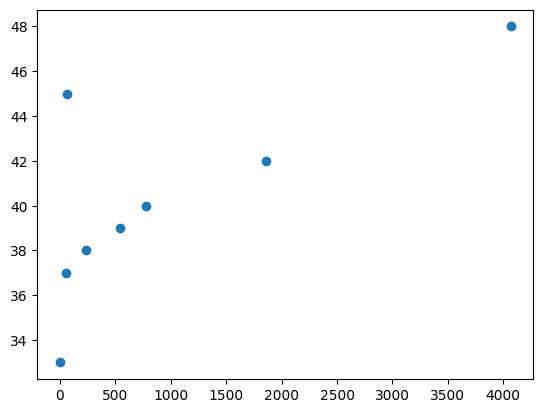

In [12]:
plt.scatter(pr, t_n)

In [13]:
np.mean(t_n)

40.25

In [14]:
'''average claim size for one disaster'''
one_pr = [int(p) / int(t) for p,t in zip(pr, t_n)]
print(one_pr)
np.mean(one_pr)

[44.357142857142854, 19.375, 1.3555555555555556, 1.5405405405405406, 13.76923076923077, 6.105263157894737, 0.0, 84.72916666666667]


21.403987443378888

2024-05-10 04:05:38.369 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.202963)
2024-05-10 04:05:38.370 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.180636)
2024-05-10 04:05:38.370 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.190037)
2024-05-10 04:05:38.375 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED powerlaw distribution (taking more than 30 seconds)
2024-05-10 04:05:38.398 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.200356)
2024-05-10 04:05:38.410 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=0.203718)
2024-05-10 04:05:38.464 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cosine distribution with error=0.204878)
2024-05-10 04:05:38.477 | INFO     | fitter.fitter:_fit_single_distribution:33

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
t,0.137044,1375.214385,1375.452710,inf,0.442713,0.060280
genextreme,0.147731,1138.256352,1138.494676,inf,0.172895,0.939129
exponweib,0.152035,1085.774282,1086.092048,inf,0.141385,0.989417
pareto,0.155019,1110.335350,1110.573675,inf,0.193173,0.875041
gamma,0.156595,1092.959442,1093.197766,inf,0.178348,0.924342


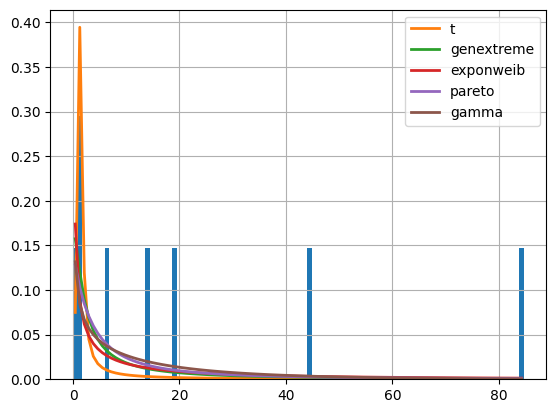

In [15]:
from fitter import Fitter, get_common_distributions


#Organize Data - from question
SR_y = pd.Series(one_pr, name="one_pr (Target Vector Distribution)")


# fitter
distributions_set = get_common_distributions()
distributions_set.extend(['arcsine', 'cosine', 'expon', 'weibull_max', 'weibull_min', 
                          'dweibull', 't', 'pareto', 'exponnorm', 'lognorm',
                          "norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"])  

f = Fitter(SR_y, distributions = distributions_set) 
f.fit()
f.summary()

In [16]:
f.fitted_param

{'expon': (0.0, 21.403987443378888),
 'cauchy': (5.539946008945577, 7.834912394967771),
 'norm': (21.403987443378888, 27.586250546900427),
 'rayleigh': (-19.255745872065607, 34.74345357415862),
 'uniform': (0.0, 84.72916666666667),
 'cosine': (27.234836621268897, 24.808168039793042),
 'arcsine': (-8.346334143691877, 93.07550081035856),
 'gamma': (0.6259824288807403, -3.9492801699422135e-26, 23.32776961739031),
 'exponpow': (0.3936273656131966, -8.072278938532839e-28, 85.42684770982754),
 'pareto': (0.9939211785143334, -6.88552653174501, 6.885526531745009),
 'chi2': (1.3528057118781946, -7.768865387758046e-28, 1.8899640952115955),
 'weibull_max': (0.22141217461326304, 84.72916666666669, 1.7240357341154278),
 'dweibull': (0.963994541817563, 13.769230769230766, 23.6780930961463),
 'lognorm': (11.757173619566988, -2.1987894247530693e-26, 4.949069789811263),
 'weibull_min': (0.582452677403554, -6.49065973670427e-27, 26.21706706991337),
 'exponnorm': (1984.7667314390796, -0.0337884153533274,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


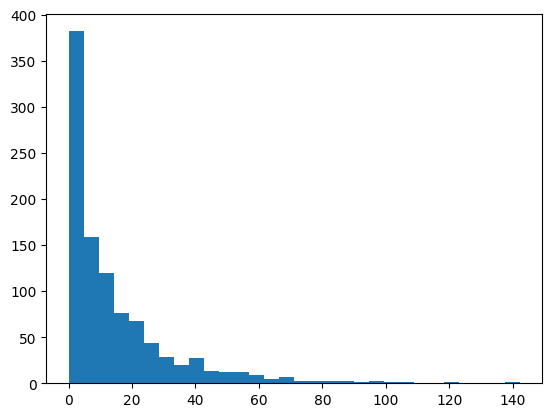

In [17]:
from scipy.stats import gamma

r = gamma.rvs(0.6259824288807403, -3.9492801699422135e-26, 23.32776961739031, size =1000)

abs_r = []

for i in r:
    if i >= 0:
        abs_r.append(i)
    if i < 0:
        abs_r.append(0)
        
plt.hist(abs_r, bins=30, histtype="stepfilled")
#plt.set_xlim([x[0], x[-1]])
plt.legend(loc='best', frameon=False)
plt.show()

((array([-3.19758950e+00, -2.93237785e+00, -2.78437841e+00, -2.67999560e+00,
         -2.59855946e+00, -2.53139899e+00, -2.47402263e+00, -2.42379214e+00,
         -2.37902149e+00, -2.33856546e+00, -2.30160949e+00, -2.26755284e+00,
         -2.23593934e+00, -2.20641415e+00, -2.17869564e+00, -2.15255643e+00,
         -2.12781017e+00, -2.10430217e+00, -2.08190261e+00, -2.06050135e+00,
         -2.04000420e+00, -2.02032992e+00, -2.00140792e+00, -1.98317650e+00,
         -1.96558137e+00, -1.94857451e+00, -1.93211325e+00, -1.91615948e+00,
         -1.90067901e+00, -1.88564107e+00, -1.87101783e+00, -1.85678408e+00,
         -1.84291686e+00, -1.82939524e+00, -1.81620005e+00, -1.80331371e+00,
         -1.79072004e+00, -1.77840415e+00, -1.76635224e+00, -1.75455157e+00,
         -1.74299028e+00, -1.73165738e+00, -1.72054262e+00, -1.70963644e+00,
         -1.69892989e+00, -1.68841463e+00, -1.67808281e+00, -1.66792707e+00,
         -1.65794051e+00, -1.64811661e+00, -1.63844924e+00, -1.62893261e+00,

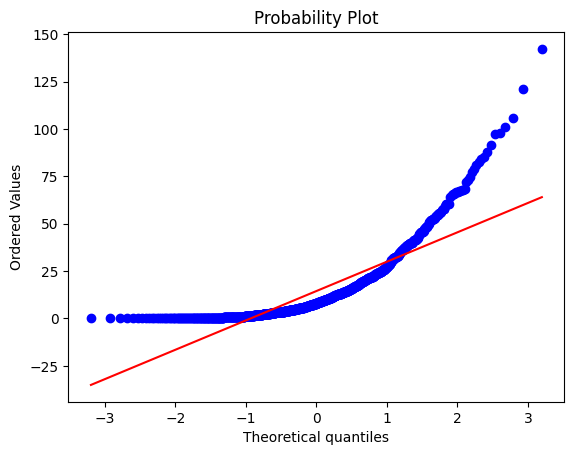

In [18]:
stats.probplot(abs_r, plot=plt)

In [19]:
claims = {}
for t in tqdm(years):
    claims_t = []
    for i in range(10000):
        rvs = poisson.rvs(40.25*t)*gamma.rvs(0.6259824288807403, -3.9492801699422135e-26, 23.32776961739031)
        if rvs >= 0:
            claims_t.append(rvs)
        if rvs < 0:
            claims_t.append(0)
        claims[f'X_{t}'] = claims_t

100%|███████████████████████████████████████████| 61/61 [00:30<00:00,  1.99it/s]


In [20]:
sorted_claims = {k: sorted(v) for k, v in claims.items()}

In [21]:
cdf_all = pd.DataFrame(sorted_claims)
cdf_all

,X_0.0,X_0.08333333333333333,X_0.16666666666666666,X_0.25,X_0.3333333333333333,X_0.4166666666666667,X_0.5,X_0.5833333333333334,X_0.6666666666666666,X_0.75,...,X_4.25,X_4.333333333333333,X_4.416666666666667,X_4.5,X_4.583333333333333,X_4.666666666666667,X_4.75,X_4.833333333333333,X_4.916666666666667,X_5.0
0,0.0,0.000000,0.000000,0.000011,4.735312e-07,0.000230,0.000021,0.000106,0.001126,0.000085,...,0.001913,0.000442,0.001274,0.001611,0.002934,0.000028,0.001595,0.000064,0.002648,0.000104
1,0.0,0.000000,0.000000,0.000016,6.363103e-05,0.000413,0.000028,0.000456,0.001706,0.000465,...,0.005142,0.000798,0.002949,0.007890,0.008185,0.005163,0.009868,0.000510,0.003211,0.001947
2,0.0,0.000000,0.000000,0.000019,9.397803e-05,0.001462,0.000192,0.001091,0.001762,0.000934,...,0.005223,0.002619,0.007807,0.013402,0.023915,0.026276,0.026440,0.002415,0.019827,0.004951
3,0.0,0.000000,0.000000,0.000032,1.390841e-04,0.001538,0.000391,0.001239,0.001763,0.001027,...,0.024987,0.003598,0.013095,0.015349,0.026478,0.026379,0.038990,0.010106,0.028977,0.018178
4,0.0,0.000000,0.000000,0.000046,1.992377e-04,0.002115,0.000718,0.001653,0.001797,0.001218,...,0.045140,0.006323,0.017431,0.018680,0.031226,0.029789,0.053767,0.018933,0.029501,0.072174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,694.607275,1464.379681,1963.813235,2.390328e+03,2563.227901,3685.918014,3806.475548,5254.114848,4580.703269,...,29152.896852,28156.639247,27593.367778,28685.341860,28536.229912,35618.420698,32856.624182,30419.581160,32272.501189,29554.967106
9996,0.0,716.154027,1572.982060,2052.312810,2.415151e+03,2681.820844,3744.994867,4619.752943,5456.816136,4715.323710,...,30135.156938,29132.940702,27757.321214,29280.717345,28630.206653,37038.879094,33614.131597,30661.473404,32715.327182,31448.975441
9997,0.0,722.299450,1645.202695,2264.982667,2.636356e+03,2704.844254,4286.442058,4760.807780,6326.798795,4970.459508,...,31412.260953,29319.447834,30619.265023,29637.860724,29681.322480,37781.480550,35189.865074,36597.167285,33531.694686,31882.385332
9998,0.0,844.856944,1739.600758,2381.045244,2.732757e+03,2707.363627,4381.726632,4869.704851,6858.855245,5472.793163,...,38502.682415,37334.301353,34138.640834,29898.836587,30489.757332,46142.877310,38988.583485,37653.793444,33904.267117,38471.086170


In [22]:
def integrand(x):
    return a

prob = []

for i in range(1,10001):
    prob.append(i/10000)

for i in years:
    cdf_all[f'prob_{i}'] = prob
    
for i in years:
    cdf_all[f'prob_{i}'][(cdf_all[f'X_{i}']==0)] = 0

n= -1
for i in years:
    n+=1
    cdf_all[f'rate_{i}'] = rate[n]

n= -1
for i in years:
    n+=1
    a = rate[n]
    cdf_all[f'discount_{i}'] = math.exp(-quad(integrand, 0, i)[0])

for i in years:
    cdf_all[f'V_{i}'] = cdf_all[f'discount_{i}']*cdf_all[f'prob_{i}']

/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_99036/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'rate_{i}'] = rate[n]
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_99036/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'rate_{i}'] = rate[n]
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_99036/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_99036/548078112.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'V_{i}'] = cdf_all[f'discount_{i}']*cdf_all[f'prob_{i}']
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_99036/548078112.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'V_{i}'] = cdf_all[f'discount_{i}']*cdf_all[f'prob_{i}']
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_99036/548078112.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usu

In [23]:
X_0 = []
Y_0 = []
Z_0 = []

for i in years:
    for n in cdf_all[f'X_{i}'].tolist():
        X_0.append(n)

for i in years:
    for n in cdf_all[f'V_{i}'].tolist():
        Y_0.append(n)

for i in years:
    for n in range(10000):
        Z_0.append(i)


X = X_0
Y = Y_0
Z = Z_0

plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10),np.linspace(np.min(Y),np.max(Y),10))
plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')


@interact(elev=IntSlider(min=-180, max=180, step=10, value=30, continuous_update=False), azim=IntSlider(min=-180, max=180, step=10, value=30, continuous_update=False))
def plot_3d(elev, azim):
    #Figure settings
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(111, projection='3d')
    #Display 3D graph
    ax.plot_surface(plotx,plotz,ploty,cstride=1,rstride=1,cmap='viridis')
    ax.set_xlabel('D (критический уровень триггера)') 
    ax.set_ylabel('T (срок, лет)') 
    ax.set_zlabel('V (Стоимость) ')
    
    #Set the initial value of the viewing direction of the 3D graph
    ax.view_init(elev=elev, azim=azim)
    plt.show()

interactive(children=(IntSlider(value=30, continuous_update=False, description='elev', max=180, min=-180, step…

In [24]:
# Expected loss 2%
s_2 = round(((1/cdf_all['V_2.0'][9800])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9800])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9800])**(1/4)-1-0.1192)*100, 3)

print('Expected loss 2%')
print(round(cdf_all['X_2.0'][9800], 3), round(cdf_all['X_3.0'][9800], 3), round(cdf_all['X_4.0'][9800], 3))
print(round(cdf_all['V_2.0'][9800], 4), round(cdf_all['V_3.0'][9800], 4), round(cdf_all['V_4.0'][9800], 4))
print(s_2, s_3, s_4)
print()

# Expected loss 2,5%
s_2 = round(((1/cdf_all['V_2.0'][9750])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9750])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9750])**(1/4)-1-0.1192)*100, 3)
print('Expected loss 2,5%')
print(round(cdf_all['X_2.0'][9750], 3), round(cdf_all['X_3.0'][9750], 3), round(cdf_all['X_4.0'][9750], 3))
print(round(cdf_all['V_2.0'][9750], 4), round(cdf_all['V_3.0'][9750], 4), round(cdf_all['V_4.0'][9750], 4))
print(s_2, s_3, s_4)
print()

# Expected loss 3%
s_2 = round(((1/cdf_all['V_2.0'][9700])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9700])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9700])**(1/4)-1-0.1192)*100, 3)
print('Expected loss 3%')
print(round(cdf_all['X_2.0'][9700], 3), round(cdf_all['X_3.0'][9700], 3), round(cdf_all['X_4.0'][9700], 3))
print(round(cdf_all['V_2.0'][9700], 4), round(cdf_all['V_3.0'][9700], 4), round(cdf_all['V_4.0'][9700], 4))
print(s_2, s_3, s_4)

Expected loss 2%
5662.479 8534.062 11637.537
0.7581 0.6672 0.5875
2.301 2.278 2.299

Expected loss 2,5%
5285.971 7977.277 10804.591
0.7542 0.6638 0.5845
2.595 2.474 2.446

Expected loss 3%
4965.256 7559.108 10195.207
0.7504 0.6604 0.5815
2.891 2.67 2.593
